In [81]:
import pandas as pd
import numpy as np

In [1]:
# --- PATHS & FLAGS ----------------------------------------------------
from pathlib import Path
import pandas as pd, requests, io

# Base URL of my GitHub repo
BASE_URL = ("https://raw.githubusercontent.com/"
            "Eugine-Srb/Sales-Forecasting_2024-Project/main/")


DATA_PROC_URL = BASE_URL + "data/processed/"     # for imports

# Local fallback folders (never pushed)
EXPORT_DIR = Path("../scratch_outputs")
EXPORT_DIR.mkdir(exist_ok=True)

# Master switch — keep False unless *really* want to re-export
SAVE_OUTPUTS = False

In [2]:
# Loading Product Sakes interpolated dataset

def load_processed(name: str) -> pd.DataFrame:
    """Load a frozen CSV straight from GitHub raw URL."""
    url = DATA_PROC_URL + name
    return pd.read_csv(url, low_memory=False)   # pandas handles https URLs

# EXAMPLE
df = load_processed("03_product_sales_interpolated_data.csv")

C:\Users\eugin\anaconda_3\Lib\ssl.py:524: UserWarning: Bad certificate in Windows certificate store: not enough data: cadata does not contain a certificate (_ssl.c:3964)
  warnings.warn(f"Bad certificate in Windows certificate store: {exc!s}")


In [83]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [84]:
# Aggregate monthly revenue across all products
df_monthly = df.groupby('Date')['Revenue'].sum().reset_index()

In [85]:
df_prophet = df_monthly.rename(columns={'Date':'ds', 'Revenue': 'y'})

In [86]:
from prophet import Prophet

In [87]:
# Prophet additive model
model_add = Prophet (yearly_seasonality = True, weekly_seasonality = False, daily_seasonality = False)

In [88]:
model_add.fit(df_prophet)

22:35:34 - cmdstanpy - INFO - Chain [1] start processing
22:35:35 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
future_add = model_add.make_future_dataframe(periods=13, freq='MS')

In [90]:
# Define future dates for forecasting
future_1 = model_add.make_future_dataframe(periods=12, freq='ME')

# Forecast on those dates
forecast_add = model_add.predict(future_1)

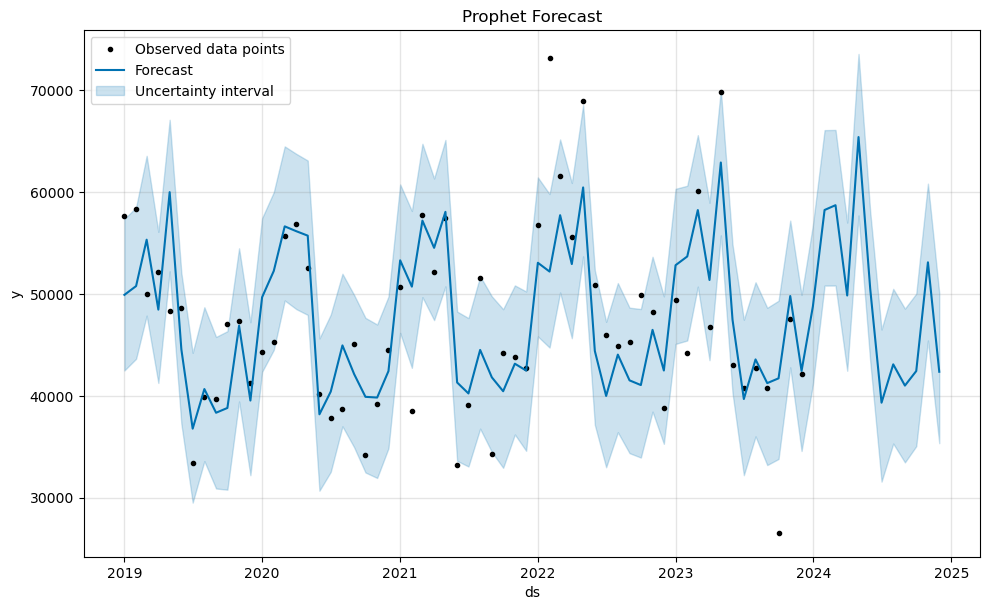

In [91]:
import matplotlib.pyplot as plt
model_add.plot(forecast_add)
plt.title("Prophet Forecast")
plt.legend()
plt.show();

In [92]:
# Prophet multiplicative model
model_mult = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'  # or 'additive'
)

In [93]:
# Add monthly seasonality
model_mult.add_seasonality(
    name='monthly',
    period=30.5,      # ~1 month
    fourier_order=5   # higher = more flexible
)

In [94]:
model_mult.fit(df_prophet)

22:35:35 - cmdstanpy - INFO - Chain [1] start processing
22:35:41 - cmdstanpy - INFO - Chain [1] done processing


In [95]:
future_mult = model_mult.make_future_dataframe(periods=13, freq='MS')

In [96]:
forecast_mult = model_mult.predict(future_mult)

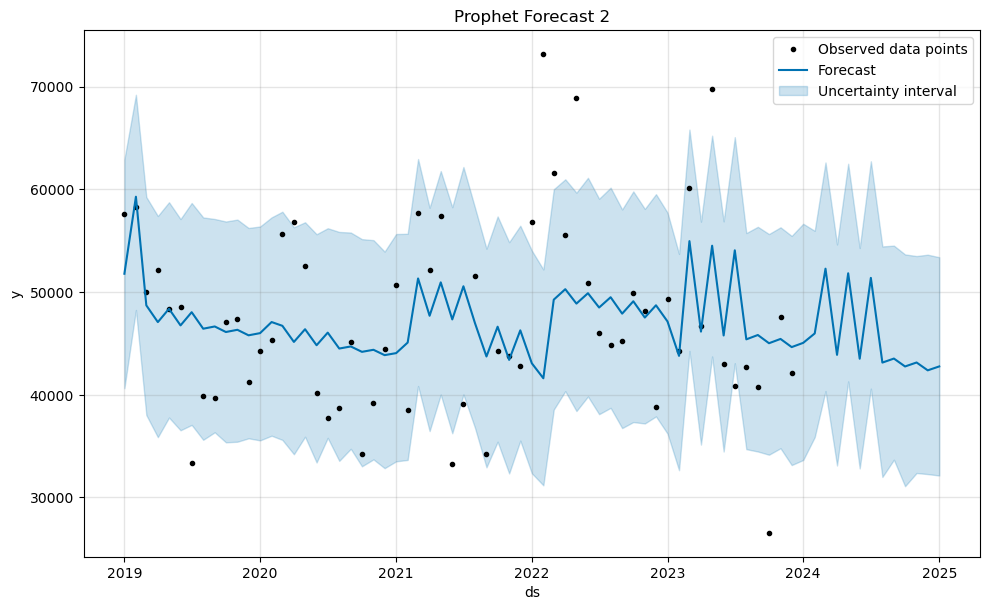

In [97]:
model_mult.plot(forecast_mult)
plt.title("Prophet Forecast 2")
plt.legend()
plt.show();

In [98]:
add_2024 = forecast_add[forecast_add['ds'].dt.year == 2024][['ds', 'yhat']].set_index('ds')
mult_2024 = forecast_mult[forecast_mult['ds'].dt.year == 2024][['ds', 'yhat']].set_index('ds')

In [99]:
forecast_comparison = pd.DataFrame({
                                    'Additive': add_2024['yhat'],
                                    'Multiplicative': mult_2024['yhat'],
                                    'Relative Diff %': 100 * (mult_2024['yhat'] - add_2024['yhat']) / add_2024['yhat']
})
forecast_comparison.index.name = 'Date'

In [100]:
forecast_comparison['Absolute Diff'] = (forecast_comparison['Multiplicative'] - forecast_comparison['Additive']).abs()
summary_stats = forecast_comparison[['Relative Diff %', 'Absolute Diff']].agg(['mean', 'std', 'max'])

In [101]:
summary_stats

,Relative Diff %,Absolute Diff
mean,NaN,NaN
std,NaN,NaN
max,NaN,NaN


In [102]:
# Mean Relative Diff %	-6.23%	On average, the multiplicative model predicts ~6.2% lower values than the additive one.
# Max Relative Diff %	18.62%	In the most divergent month, the multiplicative model was almost 19% lower than the additive model.

In [103]:
df_monthly_regress = df.groupby('Date').agg({'Units_Sold':'sum', 
                                             'Unit_Price':'mean',
                                             'Revenue':'sum'}).reset_index()

In [104]:
df_prophet_regress = df_monthly_regress.copy()
df_prophet_regress.rename(columns={'Date': 'ds','Revenue':'y'}, inplace=True)

In [105]:
model_regress = Prophet(seasonality_mode='additive')

model_regress.add_regressor('Units_Sold')
model_regress.add_regressor('Unit_Price')

model_regress.fit(df_prophet_regress)

22:35:42 - cmdstanpy - INFO - Chain [1] start processing
22:35:42 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
future_regress = model_regress.make_future_dataframe(periods=12, freq='MS')
future_regress['Units_Sold'] = df['Units_Sold'].mean()
future_regress['Unit_Price'] = df['Unit_Price'].mean()

In [107]:
forecast_regress = model_regress.predict(future_regress)

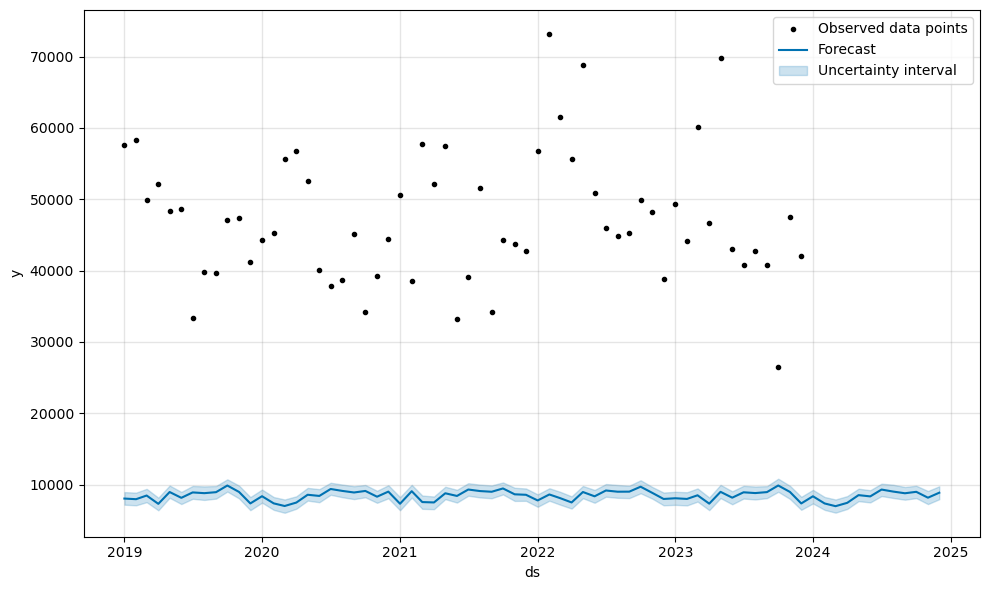

In [108]:
model_regress.plot(forecast_regress)
plt.legend();

In [109]:
monthly_avg = df_monthly_regress.groupby(df_monthly_regress['Date'].dt.month).agg({
                                        'Units_Sold':'mean',
                                        'Unit_Price':'mean'
                                        }).rename_axis('Month')

In [110]:
future_regress['Month'] = future_regress['ds'].dt.month
future_regress['Units_Sold'] = future_regress['Month'].map(monthly_avg['Units_Sold'])
future_regress['Unit_Price'] = future_regress['Month'].map(monthly_avg['Unit_Price'])
future_regress.drop(columns='Month', inplace=True)

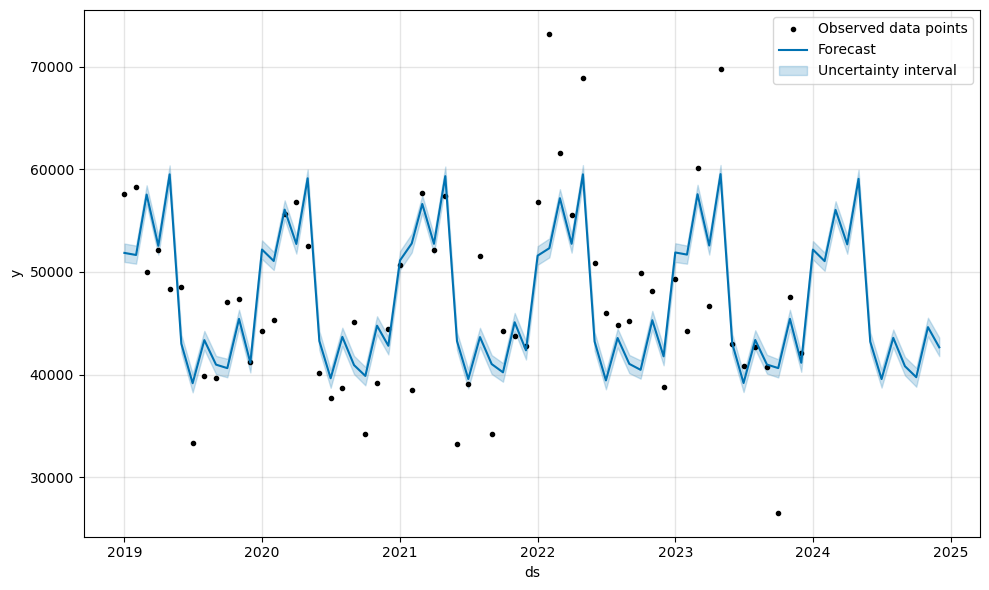

In [111]:
forecast_regress = model_regress.predict(future_regress)
model_regress.plot(forecast_regress)
plt.legend();

In [112]:
# Final forecast export
df_forecast = forecast_add[['ds', 'yhat']].copy()
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])
df_forecast.set_index('ds', inplace=True)

In [113]:
# Forecast: future predictions. Round to 1st of each month
prophet_forecast = df_forecast[df_forecast.index >= '2023-12-31'].copy()

from pandas.tseries.offsets import MonthBegin

# Move each date to the *first day of the next month*
prophet_forecast.index = (prophet_forecast.index + MonthBegin(1))

# Remove duplicates (if Prophet generated multiple rows per month-end)
prophet_forecast = prophet_forecast[~prophet_forecast.index.duplicated()]

prophet_forecast.rename(columns={'yhat': 'Prophet_forecast'}, inplace=True)

# Fitted: historical predictions
prophet_fitted = df_forecast[df_forecast.index < '2023-12-31'].copy()
prophet_fitted.rename(columns={'yhat': 'Prophet_fitted'}, inplace=True)

In [114]:
df_prophet_combined = prophet_fitted.join(prophet_forecast, how='outer')


In [115]:
df_prophet_combined['Prophet_Predicted'] = df_prophet_combined['Prophet_fitted'].combine_first(
    df_prophet_combined['Prophet_forecast']
)

In [116]:
df_prophet_combined = df_prophet_combined.reset_index().rename(columns={'ds': 'Date'})

 **Model registry** – Prophet  
> The file `models/prophet_model.json` stores the **additive-trend Prophet model** trained on monthly revenue (no multiplicative trend or custom regressors).  
> Reload with:
> ```python
> from prophet.serialize import model_from_json
> with open("models/prophet_model.json") as f:
>     prophet_add = model_from_json(f.read())
> ```

In [ ]:
def maybe_save(df: pd.DataFrame, filename: str):
    """
    Save to scratch_outputs/ only if SAVE_OUTPUTS is True.
    Prevents overwriting the canonical CSVs in data/processed/.
    """
    if SAVE_OUTPUTS:
        df.to_csv(EXPORT_DIR / filename, index=False)
        print(f"🔸 Saved {filename} to {EXPORT_DIR}")
    else:
        print(f"⏩ Skipped saving {filename} (SAVE_OUTPUTS = False)")

In [ ]:
# Export Best Prophet model results
maybe_save(df_prophet_combined, "12-best_Prophet_Model_Project2.csv")

In [118]:
# Compute description
desc_stats = df_prophet_combined['Prophet_forecast'].describe()

# Convert to DataFrame (for saving with labels)
desc_df = desc_stats.to_frame(name='Prophet_forecast')

# Optional: reset index for better CSV layout
desc_df.reset_index(inplace=True)
desc_df.rename(columns={'index': 'Statistic'}, inplace=True)


In [ ]:
# Export Prophet model statistics
maybe_save(desc_df, "13-Prophet_Project2_Forecast_Stat.csv")